/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


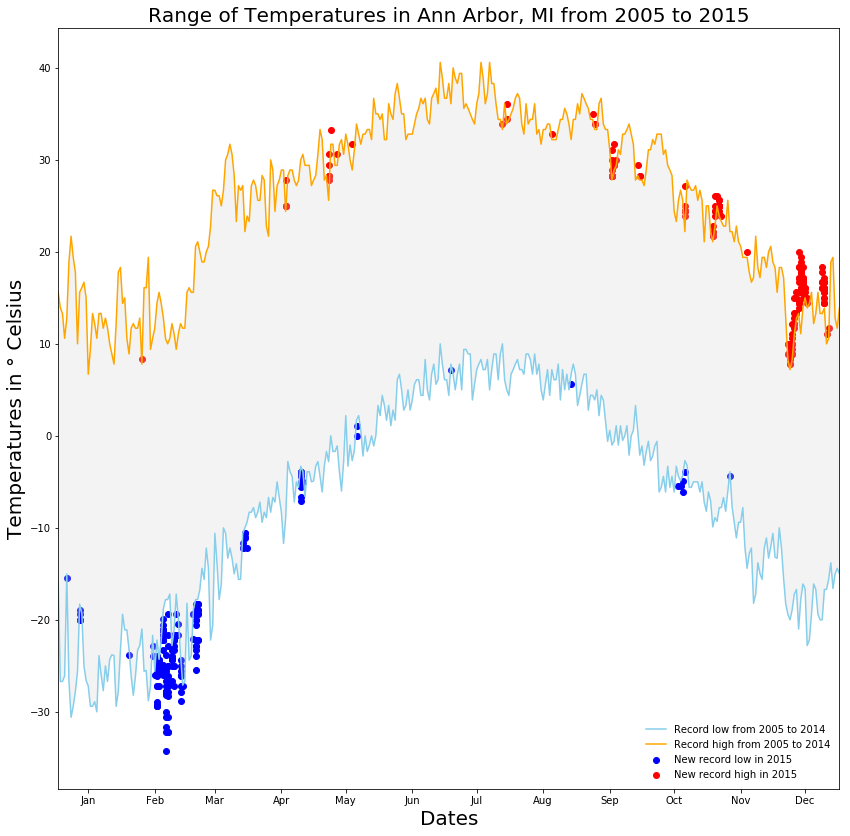

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

# leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

#~~Read data

df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df['Date']=pd.to_datetime(df['Date'])

df['test']=df['Date'].dt.strftime('%m-%d')
#~~Drop leap day data
df=df[df['test']!='02-29']
df['Data_Value']=df['Data_Value']/10

#~~Split into pre or post 2015

dfpre = df[pd.DatetimeIndex(df['Date']).year < 2015]
df2015 = df[pd.DatetimeIndex(df['Date']).year == 2015]
dfpre.rename(columns = {'Data_Value':'Pre2015'},inplace=True)
# print(dfpre)
# print(df2015)

#~~Split into Max or Min temps

dfmin = dfpre[dfpre['Element']=='TMIN']
dfmax = dfpre[dfpre['Element']=='TMAX']
dfmin2=dfmin.groupby('test').aggregate({'Pre2015':'min'}).reset_index(drop=False)
dfmax2=dfmax.groupby('test').aggregate({'Pre2015':'max'}).reset_index(drop=False)
# print(dfmin2)
# print(dfmax2)

#~~Re-merge 2015 data with record from 2005-2014

df2015min = df2015[df['Element']=='TMIN'].merge(dfmin2.reset_index(drop=False),on='test')
df2015max = df2015[df['Element']=='TMAX'].merge(dfmax2.reset_index(drop=False),on='test')


# print(df2015min)
# print(df2015max)

#~~Pull out 2015 new records

new2015low = df2015min[df2015min['Data_Value']<df2015min['Pre2015']]
new2015high = df2015max[df2015max['Data_Value']>df2015max['Pre2015']]
# print(new2015low)
# print(new2015high)

#~~Create a range of 2015 dates and join to the 2015 dataframes above
dates=np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')
datesdf = pd.DataFrame(dates)
datesdf.rename(columns = {0:'2015dates'},inplace=True)
datesdf['test']=datesdf['2015dates'].dt.strftime('%m-%d')

new2015low2=datesdf.merge(new2015low,on='test',how='left')
new2015high2=datesdf.merge(new2015high,on='test',how='left')
# print(new2015low2)
# print(new2015high2)

#~~Start the plot

plt.figure(figsize=(14,14))
ax=plt.gca()
pre2015mins = dfmin2['Pre2015'].values
pre2015maxes = dfmax2['Pre2015'].values

#~~Plot 2005-2014 records
plt.plot(dates,pre2015mins,'-',color='skyblue')
plt.plot(dates,pre2015maxes,'-',color='orange')

#~~Plot 2015 records

plt.scatter(new2015low2['2015dates'].values,new2015low2['Data_Value'].values,color='blue')
plt.scatter(new2015high2['2015dates'].values,new2015high2['Data_Value'].values,color='red')

#~~Create labels and legend
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Temperatures in ° Celsius',fontsize=20)
plt.title('Range of Temperatures in Ann Arbor, MI from 2005 to 2015',fontsize=20)
plt.legend(['Record low from 2005 to 2014','Record high from 2005 to 2014','New record low in 2015','New record high in 2015'],loc=4,frameon=False)
plt.gca().fill_between(dates,pre2015mins,pre2015maxes,facecolor='lightgrey',alpha=0.25)

#~~Change x axis margins to 0, change x axis ticks to center of month (on the 15th day of the month)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
plt.margins(x=0)
plt.show()